In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import nltk
from nltk.corpus import gutenberg
nltk.download('gutenberg')
import re
from sklearn.model_selection import train_test_split

#reading in the data, this time in the form of paragraphs
emma=gutenberg.paras('austen-emma.txt')
#processing
emma_paras=[]
for paragraph in emma:
    para=paragraph[0]
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    #Forming each paragraph into a string and adding it to the list of strings.
    emma_paras.append(' '.join(para))

print(emma_paras[0:4])

[nltk_data] Downloading package gutenberg to
[nltk_data]     /Users/karenmcgee/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
['[ Emma by Jane Austen 1816 ]', 'VOLUME I', 'CHAPTER I', 'Emma Woodhouse , handsome , clever , and rich , with a comfortable home and happy disposition , seemed to unite some of the best blessings of existence ; and had lived nearly twenty - one years in the world with very little to distress or vex her .']


In [3]:
#Happily for us, sklearn has a tfidf function that will do all our heavy lifting. It also has a very 
#long list of stop words. Since we're going to be doing dimension reduction later on anyway, let's keep all 
#the words for now.

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

X_train, X_test = train_test_split(emma_paras, test_size=0.4, random_state=0)

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


#Applying the vectorizer
emma_paras_tfidf=vectorizer.fit_transform(emma_paras)
print("Number of features: %d" % emma_paras_tfidf.get_shape()[1])

#splitting into training and test sets
X_train_tfidf, X_test_tfidf= train_test_split(emma_paras_tfidf, test_size=0.4, random_state=0)


#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of paragraphs
n = X_train_tfidf_csr.shape[0]
#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
#List of features
terms = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_train[5])
print('Tf_idf vector:', tfidf_bypara[5])

Number of features: 1948
Original sentence: A very few minutes more , however , completed the present trial .
Tf_idf vector: {'minutes': 0.7127450310382584, 'present': 0.701423210857947}


In [5]:
#Okay, now we have our vectors, with one vector per paragraph. It's time to do some dimension reduction. 
#We use the Singular Value Decomposition (SVD) function from sklearn rather than PCA because we don't 
#want to mean-center our variables (and thus lose sparsity):

In [6]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to reduce the feature space from 1379 to 130.
svd= TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_train_lsa,index=X_train)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])



Percent variance captured by all components: 45.20049828656532
Component 0:
" Oh !     0.999291
" Oh !     0.999291
" Oh !     0.999291
" Oh !     0.999291
" Oh !     0.999291
" Oh !     0.999291
" Oh !"    0.999291
" Oh !     0.999291
" Oh !"    0.999291
" Oh !     0.999291
Name: 0, dtype: float64
Component 1:
" You have made her too tall , Emma ," said Mr . Knightley .                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [7]:
#From gazing at the most representative sample paragraphs, it appears that component 0 targets the exclamation 
#'Oh!', component 1 seems to largely involve critical dialogue directed at or about the main character Emma, 
#component 2 is chapter headings, component 3 is exclamations involving 'Ah!, and component 4 involves actions 
#by or directly related to Emma.

In [8]:
#Sentence similarity
#We can also look at how similar various sentences are to one another. For example, here are the similarity 
#scores (as a heatmap) of the first 10 sentences in the training set:

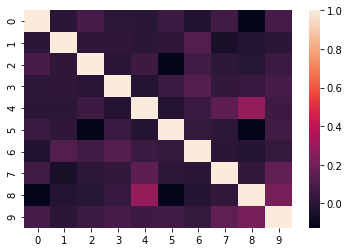

Key:
0 That is _court_ .
1 " Yes , sir , I did indeed ; and I am very much obliged by your kind solicitude about me ."
2 " How much his business engrosses him already is very plain from the circumstance of his forgetting to inquire for the book you recommended .
3 To restrain him as much as might be , by her own manners , she was immediately preparing to speak with exquisite calmness and gravity of the weather and the night ; but scarcely had she begun , scarcely had they passed the sweep - gate and joined the other carriage , than she found her subject cut up  her hand seized  her attention demanded , and Mr . Elton actually making violent love to her : availing himself of the precious opportunity , declaring sentiments which must be already well known , hoping  fearing  adoring  ready to die if she refused him ; but flattering himself that his ardent attachment and unequalled love and unexampled passion could not fail of having some effect , and in short , very much resolved on being

In [9]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[0:10,0:10]
#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(10))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i])



In [10]:
#Not much similarity at all except between sentences 8 and 9, both of which seem to describe people getting 
#along well.

# Drill 0: Test set
#Now it's your turn: Apply our LSA model to the test set. Does it identify similar sentences for 
#components 0 through 4?
# Remember, you will use the same model, only with the test set data.  Don't fit a new model by mistake!

In [12]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to reduce the feature space from 1379 to 130.
svd= TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_test_lsa = lsa.fit_transform(X_test_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_test_lsa,index=X_test)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])




Percent variance captured by all components: 49.36780913473123
Component 0:
" Oh !     0.999921
" Oh !     0.999921
" Oh !"    0.999921
" Oh !     0.999921
" Oh !     0.999921
" Oh !     0.999921
" Oh !     0.999921
" Oh !     0.999921
" Oh !     0.999921
" Oh !     0.999921
Name: 0, dtype: float64
Component 1:
" Well , Mrs . Weston ," said Emma triumphantly when he left them , " what do you say now to Mr . Knightley ' s marrying Jane Fairfax ?"                                                                                                                                                                                                                                                                                                             0.609442
After tea , Mr . and Mrs . Weston , and Mr . Elton sat down with Mr . Woodhouse to cards .                                                                                                                                                       

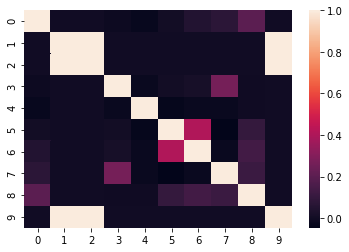

Key:
0 Mr . Woodhouse had so completely made up his mind to the visit , that in spite of the increasing coldness , he seemed to have no idea of shrinking from it , and set forward at last most punctually with his eldest daughter in his own carriage , with less apparent consciousness of the weather than either of the others ; too full of the wonder of his own going , and the pleasure it was to afford at Randalls to see that it was cold , and too well wrapt up to feel it .
1 " Oh !
2 " Oh no , no !
3 Such was Jane Fairfax ' s history .
4 " That has been a good deal the case , my dear ; but not to the degree you mention .
5 " And I am quite serious too , I assure you ," replied Mrs . Elton gaily , " in resolving to be always on the watch , and employing my friends to watch also , that nothing really unexceptionable may pass us ."
6 " And here is Mrs . Weston and Mr . Frank Churchill too ! Quite delightful ; so many friends !"
7 " You may well class the delight , the honour , and the comfo

In [13]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_test_lsa) * np.asmatrix(X_test_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_test).iloc[0:10,0:10]
#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(10))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i])



In [14]:
#Not much similarity at all except between sentences 1,9 and 2,9, both of which have the keyword Oh ! in common. 

# Drill 1: Tweaking tf-idf
#Go back up to the code where we originally translated the text from words to numbers. There are a lot of 
#decision-points here, from the stop list to the thresholds for inclusion and exclusion, and many others as well. 
#We also didn't integrate spaCy, and so don't have info on lemmas or Named Entities. Change things up a few times 
#and see how that affects the results of the LSA. Write up your observations and share them with your mentor.

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

X_train, X_test = train_test_split(emma_paras, test_size=0.4, random_state=0)

#change max_df from 0.5 to 0.55
#change min_df_2 from 2 to 1
vectorizer = TfidfVectorizer(max_df=0.55, # drop words that occur in more than half the paragraphs
                             min_df=1, # only use words that appear at least twice
                             sublinear_tf=True,
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


#Applying the vectorizer
emma_paras_tfidf=vectorizer.fit_transform(emma_paras)
print("Number of features: %d" % emma_paras_tfidf.get_shape()[1])

#splitting into training and test sets
X_train_tfidf, X_test_tfidf= train_test_split(emma_paras_tfidf, test_size=0.4, random_state=0)


#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of paragraphs
n = X_train_tfidf_csr.shape[0]
#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
#List of features
terms = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_train[5])
print('Tf_idf vector:', tfidf_bypara[5])

Number of features: 3851
Original sentence: A very few minutes more , however , completed the present trial .
Tf_idf vector: {'trial': 0.5783807823673666, 'completed': 0.5783807823673666, 'minutes': 0.4100306021374355, 'present': 0.4035173434773752}


In [17]:
#Results:
#The reduction in the change in max_df 0.55 and min_df 1 produced more vectors but with lower
#frequency.

#The reduction in the change in max_df 0.65 and min_df 2 produced similar number of vectors 
#as our original execution of the assignment 

#The reduction in the change in max_df 1.0 and min_df 2 produced similar number of vectors 
#as our original execution of the assignment 

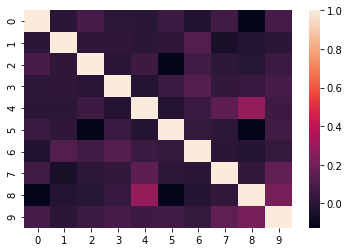

Key:
0 That is _court_ .
1 " Yes , sir , I did indeed ; and I am very much obliged by your kind solicitude about me ."
2 " How much his business engrosses him already is very plain from the circumstance of his forgetting to inquire for the book you recommended .
3 To restrain him as much as might be , by her own manners , she was immediately preparing to speak with exquisite calmness and gravity of the weather and the night ; but scarcely had she begun , scarcely had they passed the sweep - gate and joined the other carriage , than she found her subject cut up  her hand seized  her attention demanded , and Mr . Elton actually making violent love to her : availing himself of the precious opportunity , declaring sentiments which must be already well known , hoping  fearing  adoring  ready to die if she refused him ; but flattering himself that his ardent attachment and unequalled love and unexampled passion could not fail of having some effect , and in short , very much resolved on being

In [18]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[0:10,0:10]
#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(10))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i])

